# Project 2: Ames Housing Data

## Model Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pickle

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

First I'll load in the scaler, model, and dataframe columns from the last notebook.

In [2]:
with open('../assets/lasso_lin_reg.pkl', 'rb') as f:
    lasso = pickle.load(f)
with open('../assets/scaler.pkl', 'rb') as f:
    ss = pickle.load(f)
with open('../assets/columns.pkl', 'rb') as f:
    columns = pickle.load(f)

ames_dummies = '../datasets/train_clean_dummies.csv'
df = pd.read_csv(ames_dummies, index_col='Id', keep_default_na=False)

I want to examine the model a little more closely. I'll start by printing the model's alpha value.

In [3]:
lasso.alpha_

969.4358324177488

This is a very high alpha value, which indicates that the model's regularization was very aggressive. We can visualize this impact with a histogram.

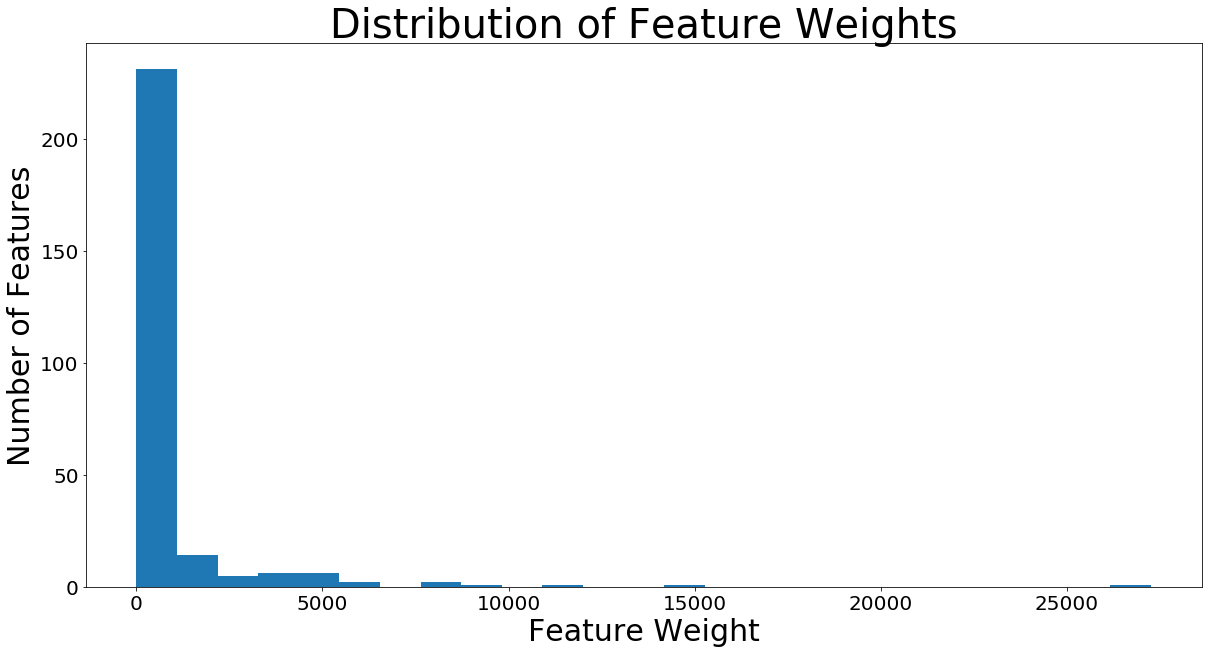

In [4]:
plt.figure(figsize=(20, 10))
plt.title('Distribution of Feature Weights', fontsize=40)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weight', fontsize=30)
plt.ylabel('Number of Features', fontsize=30)
plt.hist(np.sort(abs(lasso.coef_)), bins=25);

From this histogram we can see that the model reduced the vast majority of features to zero weight on the predictions.

I want to plot the model's intercept and its most influential beta coefficients to evaluate whether or not the model makes logical human sense. To do that, I'll first have to remove `SalePrice` from the imported list of columns since those values were not present in the training data on which the model was based.

In [5]:
columns.remove('SalePrice')

Now I'll plot the model's intercept and its most influential beta coefficients to evaluate whether or not the model makes logical human sense.

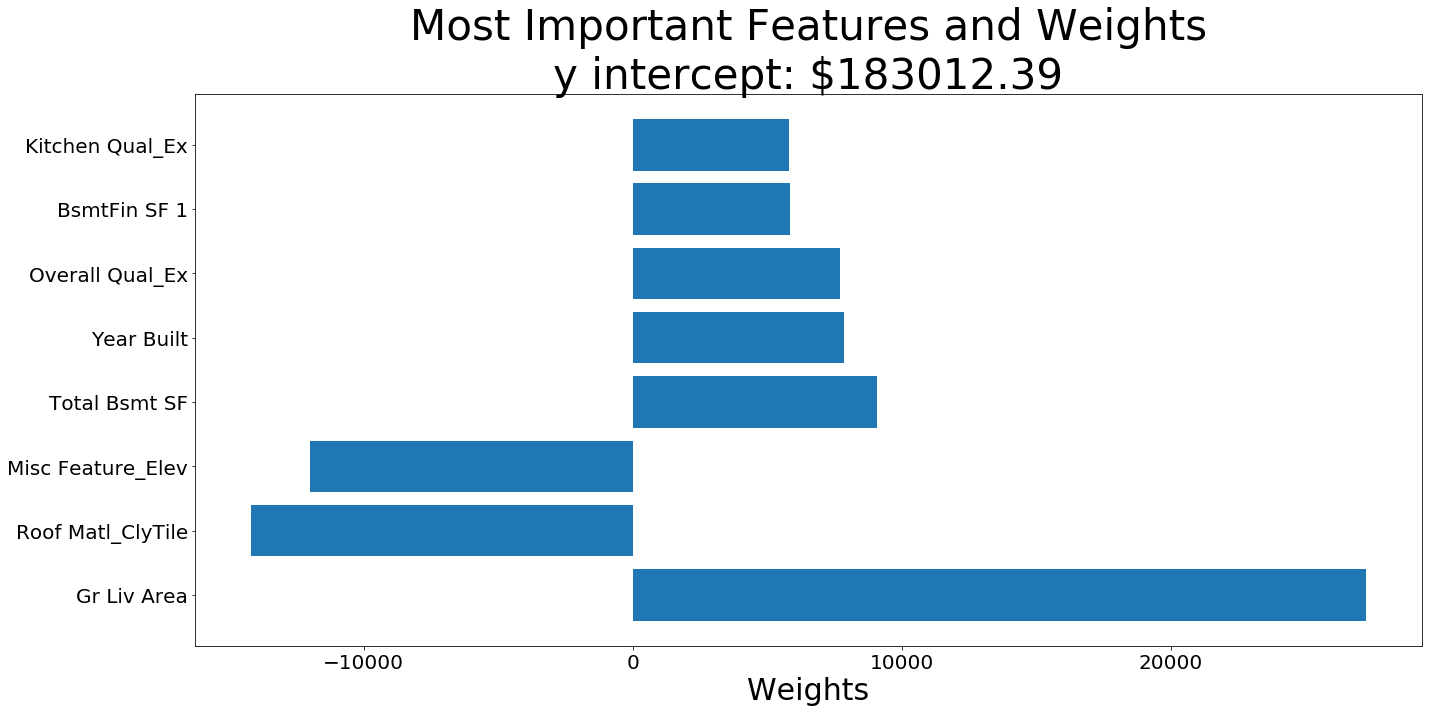

In [6]:
beta_0 = lasso.intercept_

betas = pd.DataFrame({'weights' : lasso.coef_, 'features' : columns})
betas.set_index(betas.features, inplace=True)

betas['abs_w'] = betas.weights.abs()
betas.head()

weights = betas.sort_values('abs_w', ascending=False)['weights'].head(8)
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

It's strange that `Misc Feature_Elev` and `Roof Matl_ClyTile` have such an outsized negative impact on price in this model. I need to pull in the training dataset to see what might be creating that weight in the properties with those features.

In [7]:
ames_raw = pd.read_csv('../datasets/train.csv')
ames_raw.loc[(ames_raw['Misc Feature'] == 'Elev')]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


A close look at this entry raises questions. It's a new home on a very large lot, so it should be a highly-valued property. We can infer either that there was human error in entering this property's data, or that there are some other extenuating circumstances surrounding this property that drove down its sale price. In any event, for the purposes of modeling it makes the most sense to eliminate this property from our training set.

In [8]:
df.drop(index=2181, inplace=True)

Next I want to take a look at the property with the clay tile roof.

In [9]:
ames_raw.loc[(ames_raw['Roof Matl'] == 'ClyTile')]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,0,480,Gd,NaN,NaN,0,1,2008,New,160000


This property also seems to be an outlier, so the model would be best served by dropping it from the training set.

In [10]:
df.drop(index=1499, inplace=True)

Now that the offending properties have been removed from the training data, I will split and scale the data again, and then fit a new lasso model to it. This new model should perform better than the original one.

In [11]:
X=df.drop(columns='SalePrice')
y=df.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

lasso = LassoCV(cv=5)

lasso.fit(X_train_sc, y_train);

/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/BK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


The model is now fit to the revised training data and I can get its new training score.

In [12]:
lasso.score(X_train_sc, y_train)

0.9401184802650079

This new training score marks a slight improvement over the original model. Now I will get its test score.

In [13]:
lasso.score(X_test_sc, y_test)

0.9138829845867311

This score is only very slightly worse than the original model, which was better by only .002. I'll check the new model's RMSE for more insight.

In [14]:
preds = lasso.predict(X_test_sc)
(mean_squared_error(y_test, preds)) ** .5

22420.976492041722

The new RMSE score is an improvement over the original. Here is a visualization of the new model's predictions compared to their targets.

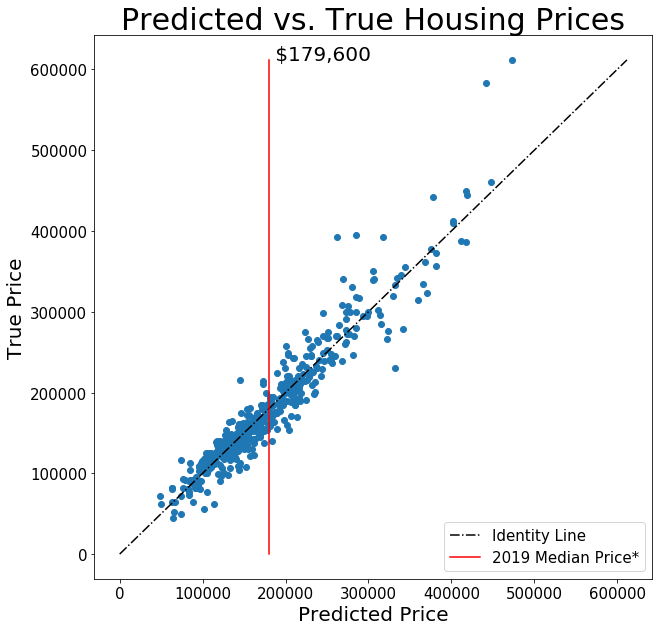

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(preds, y_test, label=None)
plt.plot((0, y_test.max()), (0,y_test.max()), 'k-.', label='Identity Line')
plt.plot((179600, 179600), (0,y_test.max()), 'r-', label='2019 Median Price*')
plt.title('Predicted vs. True Housing Prices', fontsize=30)
plt.xlabel('Predicted Price', fontsize=20)
plt.ylabel('True Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.annotate(' $179,600', (179600,y_test.max()), fontsize=20)
plt.legend(fontsize=15, loc='lower right');
# plt.savefig('../viz_exports/pred_vs_true2.png');

At the moment I'm happy with the new model's results but I want to plot the weights of its coefficients first to make sure there aren't any anomalies in it like the elevator or clay tile roof from earlier.

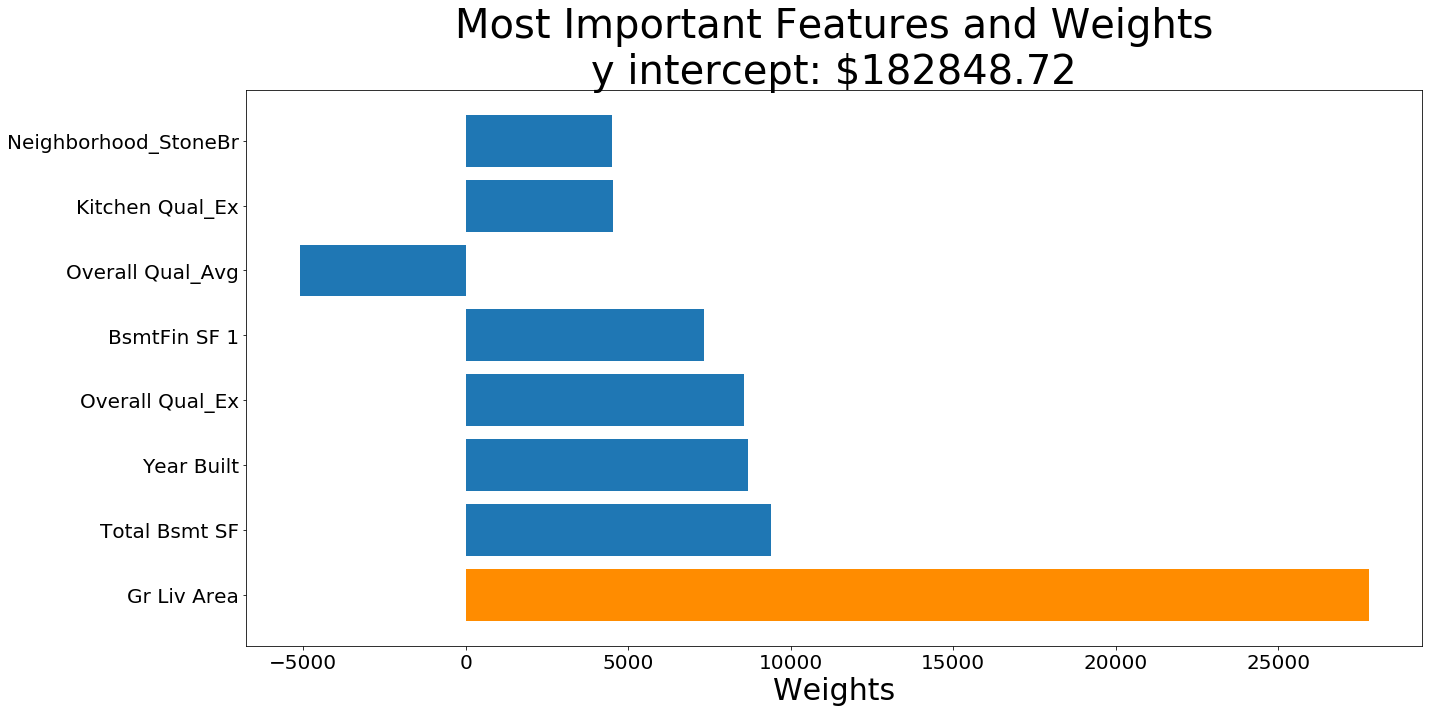

In [16]:
v2_beta_0 = lasso.intercept_
v2_betas = pd.DataFrame({'weights' : lasso.coef_, 'features' : columns})
v2_betas.set_index(v2_betas.features, inplace=True)

v2_betas['abs_w'] = v2_betas.weights.abs()

v2_weights = v2_betas.sort_values('abs_w', ascending=False)['weights'].head(8)
labels = v2_weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, v2_weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${v2_beta_0:0.02f}', fontsize=40)
plt.barh('Gr Liv Area', v2_weights['Gr Liv Area'], color='darkorange')
plt.tight_layout()
# plt.savefig('../viz_exports/coefficients1.png');

The fact that `Overall Qual_Avg` has that negative of an impact on the price prediction is odd. But the rest of the most important features and their relative impact make sense, and the model is scoring well. I'll create another visualization with an expanded set of important features to see if any other curiosities appear.

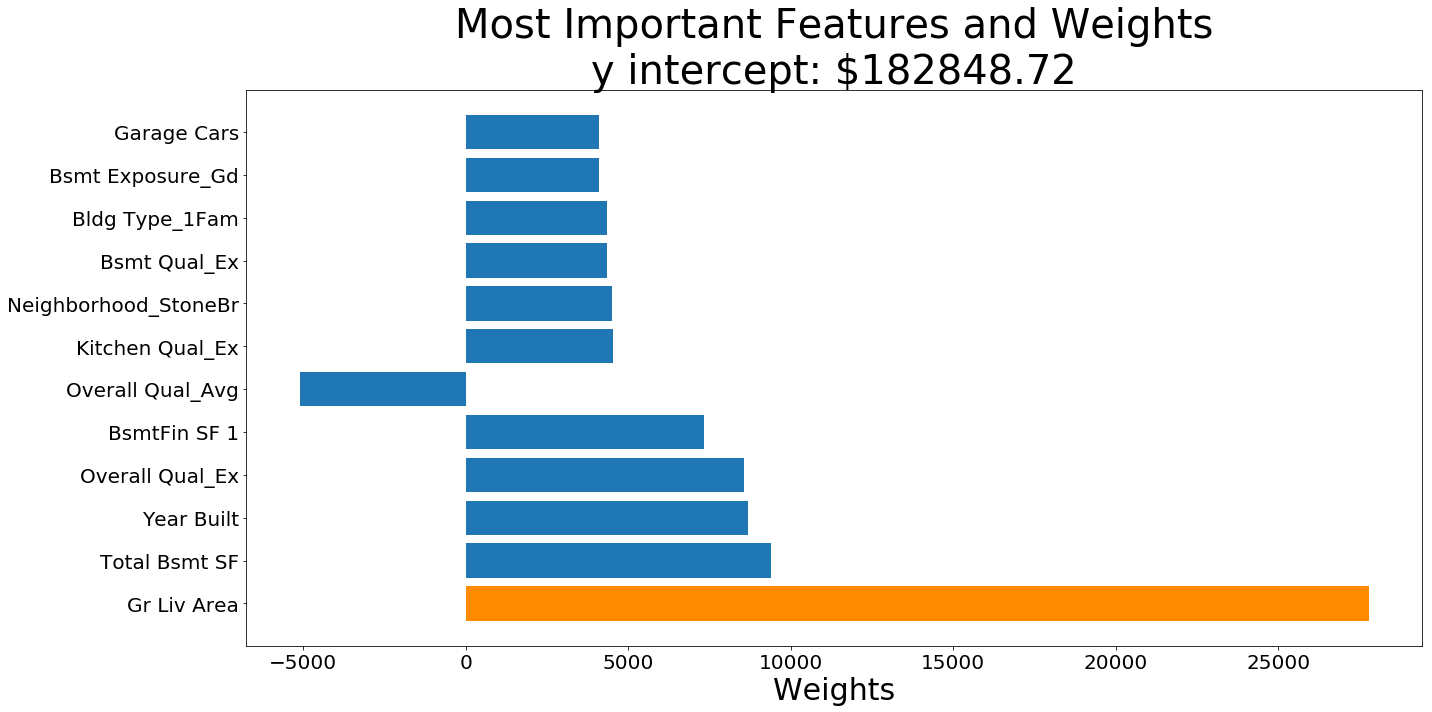

In [17]:
v2_weights = v2_betas.sort_values('abs_w', ascending=False)['weights'].head(12)
labels = v2_weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, v2_weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${v2_beta_0:0.02f}', fontsize=40)
# plt.barh('Overall Qual_Avg', v2_weights['Overall Qual_Avg'], color='darkorange')
plt.barh('Gr Liv Area', v2_weights['Gr Liv Area'], color='darkorange')
# plt.annotate(f'{v2_weights["Gr Liv Area"]:0.02f}', (0,0), fontsize=15, align=left)
plt.tight_layout()
# plt.savefig('../viz_exports/coefficients2.png');

The next four most important features include having an excellent-quality basement, being a detached single-family home, good basement exposure, and the number of cars the garage holds. It makes sense that these would have a reasonably positive impact on price, so instead of disrupting the model I'll let it stand and move on to using it for predictions.

In the following code block I'll pickle the model and scaler for use in making online predictions.

In [18]:
# with open('../assets/lasso_lin_reg.pkl', 'wb+') as f:
#     pickle.dump(lasso, f)
    
# with open('../assets/scaler.pkl', 'wb+') as f:
#     pickle.dump(ss, f)